In this workbook, we test that single predictions for LSF are being compiled in the manner that we expect. We compare between the following sources:

1. **Old Data (Draft_1)** 
2. Manual Calculation using Single Weights Sequence applied for Predictions
3. Manual Calculation using Mean of Distribution of Weights applied for Predictions
4. Auto Calculation using Mean of Distribution of Weights applied for Predictions

5. **New Data (v0/Data_v0)**
6. Manual Calculation using Single Weights Sequence applied for Predictions
7. Manual Calculation using Mean of Distribution of Weights applied for Predictions
8. Auto Calculation using Mean of Distribution of Weights applied for Predictions

9. **Testing LSF Data (v0/Data_v0/TestingLSF/)**
10. Manual Calculation using Single Weights Sequence applied for Predictions
11. Manual Calculation using Mean of Distribution of Weights applied for Predictions
12. Auto Calculation using Mean of Distribution of Weights applied for Predictions

Here, the comparison between (2, 3, 4) vs (6, 7, 8) depends on the underlying training data. In (2, 3, 4), we use a single set of training data to generate weights, and then use these weights to make predictions for a distribution of validation data. In (6, 7, 8), we use a distribution of training data sets to generate the weights, which are used to make predictions on a distribution of validation data. 


Hence, in Draft_1 , a single weight sequence == mean weight sequence, while in Data_v0, a single weight sequence != mean in general, but it may be "close" enough for simple, low noise signals. We test this hypothesis by redoing (6,7,8) with a single training data, for test case 19, variation 1, under Data_v0/TestingLSF/.


We recover the behaviour of (2,3,4) in (10, 11, 12), hence proving two things: that our v0 code is correct, and that the differences between v0 and Draft_1 data can be reconciled in a predictable way.

In [1]:
import sys
sys.path.append('../../../')
ver = 0
choose_one = 23
datapath_old= '../../DATA_v'+str(ver)+'_/' # host data from Archive/DRAFT_1
datapath_new = '../../DATA_v'+str(ver)+'/' # new data in v0/DATA_v0
datapath_lsf_tsting = datapath_new+'testingLSF/'

import numpy as np
import matplotlib.pyplot as plt
from data_tools.data_risk_analysis import sort_my_vals

from data_tools.load_raw_cluster_data import LoadExperiment as le
from plot_tools.plot_helper_funcs import plot_normed_means, plot_single_predictions

In [2]:
tc=  19
v = 1

datasets = [datapath_old, datapath_new, datapath_lsf_tsting]
plot_titles = ['using Draft_1 data (old)', 'using Data_v0 (new)', 'using Data_v0/testingLSF']

**Expected Results**

1. LSF_macro_predictions == predictions_those, if code is working correctly
2. predictions_lsf_run == predictions_mean, if code is working correctly
3. predictions_lsf_run == predictions_those, 
    
    - TRUE in DATA_v0 if the variance of weights over all runs is trivially small (within machine precision) e.g. for simple low msmt noise cases (such as tc 15, 12)
    
    - FALSE in DATA_v0 if variance of weights over all runs is not trivially small, such as in high msmt noise cases
    
    - FALSE for all cases in Draft_1, since the same measurement data was used in all training runs, so a single realisation of weights == mean over distribution of weights.

LSF: Data Loaded? Yes
Show (1) is true: -- True
Show (2) is true: -- False
Show (3) ~ true: -- True
Show (3) false: -- False


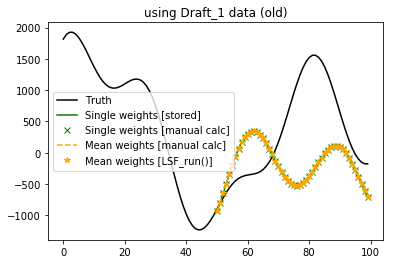

LSF: Data Loaded? Yes
Show (1) is true: -- True
Show (2) is true: -- True
Show (3) ~ true: -- False
Show (3) false: -- False


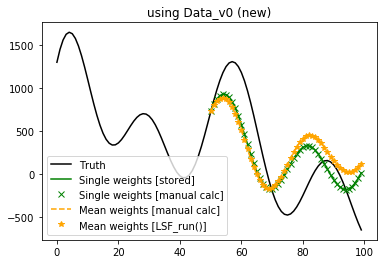

LSF: Data Loaded? Yes
Show (1) is true: -- True
Show (2) is true: -- True
Show (3) ~ true: -- True
Show (3) false: -- True


In [3]:
for idx_data in xrange(len(datasets)):
           
    
    datapath = datasets[idx_data]
    baseObj = le(tc, v,
                skip = 1,
                GPRP_load='No', GPRP_path = datapath,
                LKFFB_load = 'No', LKFFB_path = datapath,
                AKF_load='No', AKF_path = datapath,
                LSF_load = 'Yes', LSF_path = datapath)

    # recreate predictions manually using the same data...
    sequence_of_raw_data_past = baseObj.LSF_macro_data[choose_one,1900:2001]

    # ... and the same weights:
    those_weights = baseObj.LSF_macro_weights[choose_one,:,:,0]
    predictions_those = np.dot(those_weights, sequence_of_raw_data_past[::-1])

    # ... or the mean of weights for all runs:
    mean_weights = np.mean(baseObj.LSF_macro_weights[:,:,:,0], axis = 0)
    predictions_mean = np.dot(mean_weights, sequence_of_raw_data_past[::-1])

    # Now redo the mean weight calculation above using LS_run(), instead of manually:
    from data_tools.data_tuned_run_analysis import LSF_run 
    predictions_lsf_run = LSF_run(baseObj, baseObj.LSF_macro_data[choose_one,:])

    print 'Show (1) is true: --', np.all(predictions_lsf_run==predictions_mean)
    print 'Show (2) is true: --', np.all(predictions_those==baseObj.LSF_macro_predictions[choose_one,:].flatten())
    print 'Show (3) ~ true: --', np.all(baseObj.LSF_macro_predictions[choose_one,:].flatten()- predictions_lsf_run < 10**-11)
    print 'Show (3) false: --', np.all(baseObj.LSF_macro_predictions[choose_one,:].flatten()- predictions_lsf_run < 10**-12)

    plt.figure()
    plt.title(plot_titles[idx_data])
    # plot data
    plt.plot(range(100), baseObj.LSF_macro_truths[choose_one,1950:2050], 'k', label='Truth')
    # plt.plot(range(100), baseObj.LSF_macro_data[0,1950:2050], 'b--', label='Data')
    # plt.plot(range(50, 100,1), baseObj.LSF_macro_actuals[0,:], 'b--', label='Actuals (Data in Forecast Zone)')
    # plot predictions stored in LS_Ensemble.npz using single weights
    plt.plot(range(50, 100,1), baseObj.LSF_macro_predictions[choose_one,:], 'g', label='Single weights [stored]')
    # re-create the above predictions manually using the same weights to check code is working
    plt.plot(range(50, 100,1), predictions_those, 'gx', label='Single weights [manual calc]')
    # re-create the above predictions manually using mean weights for all runs in LS_Ensemble.npz
    plt.plot(range(50, 100,1), predictions_mean, '--', c='orange', label='Mean weights [manual calc]')
    # recreate the above predictions using mean weights using LS_run()
    plt.plot(range(50, 100,1), predictions_lsf_run, '*', c='orange', label='Mean weights [LSF_run()]')
    plt.legend(loc=0)
    
    if idx_data !=2: 
        plt.show()
        plt.close()

Now, hypothesis that the difference btw Draft_1 and Draft_v0 is due to using the same training data set, or a distribution of training data sets respectively. To test this, we need to re-run LSF_optimisation with the same implementation as Draft_1 data. We will call this Data_v0/testing_LSF, and we will use test_case 19, variation 1 to show that yellow and green lines will be identical for most cases, to within $10^{-11}$

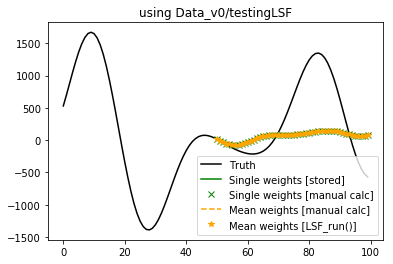

In [4]:
plt.show()
plt.close()